# Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [3]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torchvision': '0.9.0',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] torch 1.10.1
[OK] torchvision 0.11.2
[OK] numpy 1.21.5
[OK] matplotlib 3.5.1


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader
import itertools
import math
from torch.autograd import grad as torch_grad


# Implementing a GAN from scratch

In [9]:
print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.10.0+cu113
GPU Available: True


## Implementing the generator and the discriminator networks 

In [15]:
## define a function for the generator:
def make_generator_network(
        input_size=20,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', 
                         nn.Linear(input_size, 
                                   num_hidden_units)) 
        model.add_module(f'relu_g{i}', 
                         nn.LeakyReLU())     
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}', 
                    nn.Linear(input_size, num_output_units))   
    model.add_module('tanh_g', nn.Tanh())      
    return model

## define a function for the discriminator:
def make_discriminator_network(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', 
                 nn.Linear(input_size, 
                           num_hidden_units, bias=False)) 
        model.add_module(f'relu_d{i}', 
                         nn.LeakyReLU())  
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}', 
                     nn.Linear(input_size, num_output_units))   
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [16]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
 
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [17]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Defining the training dataset

 * **Step-by-step walk through the data-flow**

In [18]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)

example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [19]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [20]:
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'  # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


## Training the GAN model

In [21]:
loss_fn = nn.BCELoss()

## Loss for the Generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6983
Discriminator Losses: Real 0.7479 Fake 0.6885


 * **Final training**

In [22]:
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)
 
## Set up the models
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)
 
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)
 
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [23]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [24]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [25]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):           
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())
        
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())
 

Epoch 001 | Avg Losses >> G/D 0.9121/0.8852 [D-Real: 0.8118 D-Fake: 0.4654]
Epoch 002 | Avg Losses >> G/D 0.8739/1.2084 [D-Real: 0.5844 D-Fake: 0.4515]
Epoch 003 | Avg Losses >> G/D 0.9502/1.1968 [D-Real: 0.5794 D-Fake: 0.4297]
Epoch 004 | Avg Losses >> G/D 1.0326/1.1652 [D-Real: 0.5955 D-Fake: 0.4099]
Epoch 005 | Avg Losses >> G/D 0.9521/1.2262 [D-Real: 0.5705 D-Fake: 0.4265]
Epoch 006 | Avg Losses >> G/D 1.0270/1.1791 [D-Real: 0.5925 D-Fake: 0.4086]
Epoch 007 | Avg Losses >> G/D 0.9694/1.2090 [D-Real: 0.5791 D-Fake: 0.4223]
Epoch 008 | Avg Losses >> G/D 0.9624/1.2054 [D-Real: 0.5804 D-Fake: 0.4207]
Epoch 009 | Avg Losses >> G/D 0.9728/1.2035 [D-Real: 0.5831 D-Fake: 0.4177]
Epoch 010 | Avg Losses >> G/D 0.9112/1.2323 [D-Real: 0.5703 D-Fake: 0.4315]
Epoch 011 | Avg Losses >> G/D 0.9511/1.2256 [D-Real: 0.5724 D-Fake: 0.4241]
Epoch 012 | Avg Losses >> G/D 0.8723/1.2590 [D-Real: 0.5612 D-Fake: 0.4428]
Epoch 013 | Avg Losses >> G/D 0.9130/1.2470 [D-Real: 0.5650 D-Fake: 0.4334]
Epoch 014 | 

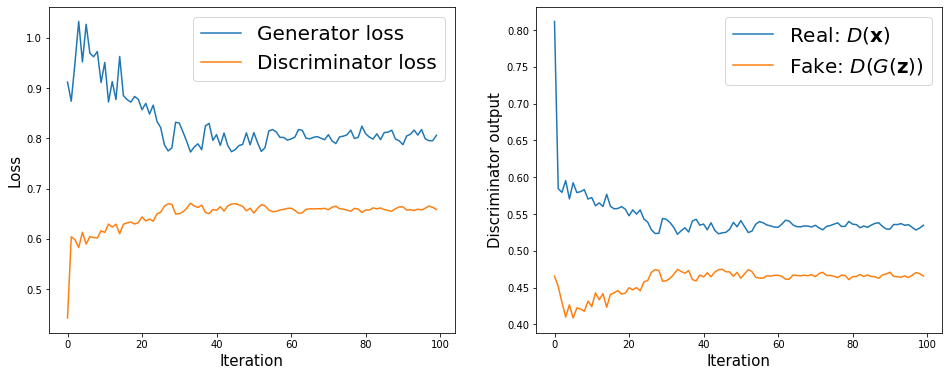

In [26]:
fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
 
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

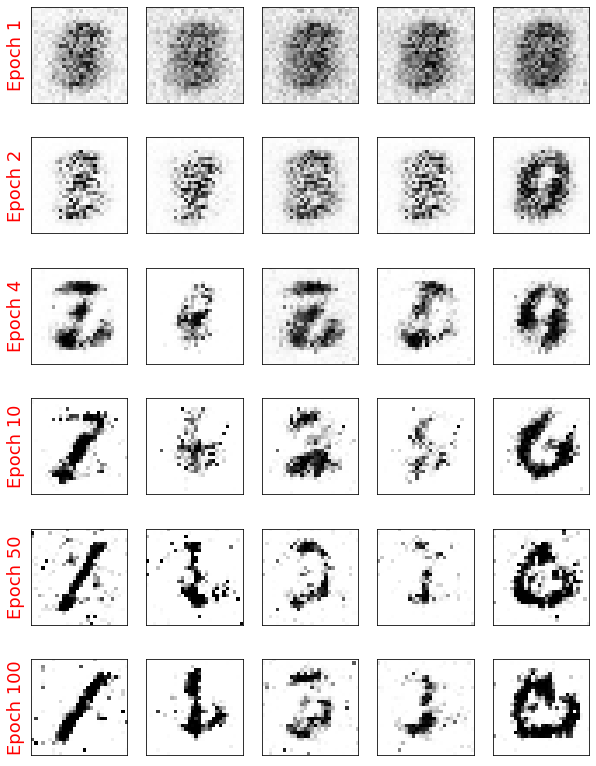

In [27]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('figures/ch17-vanila-gan-samples.pdf')
plt.show()

<br>
<br>

----

In [28]:
def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1).cuda()
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1).cuda()
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))

    del X, X2, Y, Y2
    
    if sqrt:
        M = ((M+M.abs())/2).sqrt()
    
    return M

In [29]:
def mmd(Mxx, Mxy, Myy, sigma) :
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx/(scale*2*sigma*sigma))
    Mxy = torch.exp(-Mxy/(scale*2*sigma*sigma))
    Myy = torch.exp(-Myy/(scale*2*sigma*sigma))
    a = Mxx.mean()+Myy.mean()-2*Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [30]:
def compute_score(fake, real , k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

 
    print(mmd(Mxx, Mxy, Myy, sigma))

In [31]:
whole_dl = DataLoader(mnist_dataset, batch_size=10000, 
                      shuffle=True, drop_last=True) 

In [32]:
real_image = next(iter(whole_dl))[0]

In [33]:
compute_score(torch.from_numpy(epoch_samples[-1]), real_image)

0.8969085620621585


# Improving the quality of synthesized images using a convolutional and Wasserstein GAN

## Train the DCGAN model

In [ ]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)


In [ ]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = make_generator_network(z_size, n_filters).to(device)  
print(gen_model)
disc_model = Discriminator(n_filters).to(device)     
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [ ]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()


In [ ]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
 
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.5246/0.1213
Epoch 002 | Avg Losses >> G/D 4.3550/0.1622
Epoch 003 | Avg Losses >> G/D 3.5067/0.2883
Epoch 004 | Avg Losses >> G/D 3.0862/0.3388
Epoch 005 | Avg Losses >> G/D 2.9113/0.3387
Epoch 006 | Avg Losses >> G/D 2.8452/0.3513
Epoch 007 | Avg Losses >> G/D 2.8693/0.3268
Epoch 008 | Avg Losses >> G/D 2.9476/0.3122
Epoch 009 | Avg Losses >> G/D 2.9538/0.3233
Epoch 010 | Avg Losses >> G/D 2.9754/0.3221
Epoch 011 | Avg Losses >> G/D 3.0405/0.2882
Epoch 012 | Avg Losses >> G/D 3.0717/0.2732
Epoch 013 | Avg Losses >> G/D 3.1362/0.2705
Epoch 014 | Avg Losses >> G/D 3.2441/0.2409
Epoch 015 | Avg Losses >> G/D 3.3397/0.2372
Epoch 016 | Avg Losses >> G/D 3.4194/0.2276
Epoch 017 | Avg Losses >> G/D 3.3906/0.2368
Epoch 018 | Avg Losses >> G/D 3.4867/0.2339
Epoch 019 | Avg Losses >> G/D 3.4793/0.2192
Epoch 020 | Avg Losses >> G/D 3.4953/0.2327
Epoch 021 | Avg Losses >> G/D 3.5337/0.2347
Epoch 022 | Avg Losses >> G/D 3.5944/0.1870
Epoch 023 | Avg Losses >> G/D 3.

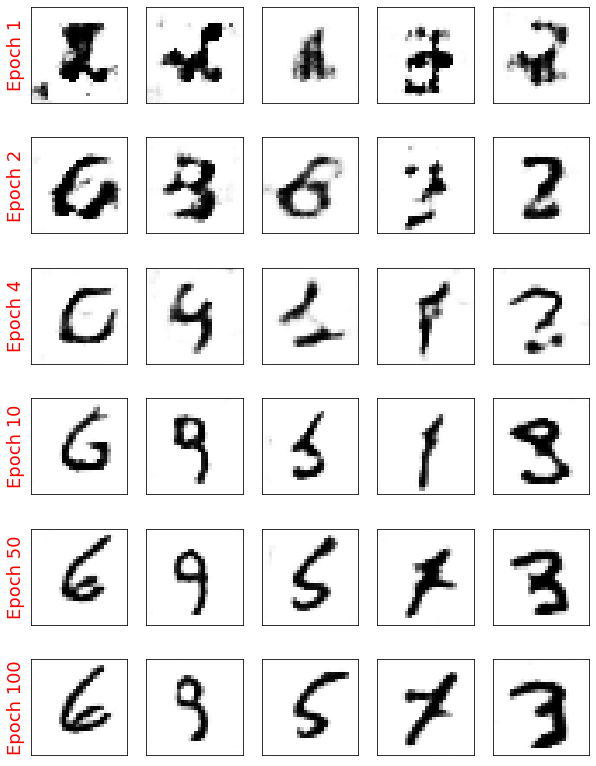

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

# Implementing WGAN-GP to train the DCGAN model

In [ ]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)  
disc_model = DiscriminatorWGAN(n_filters).to(device)  

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    
    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


In [ ]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item()

In [ ]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5 

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))
 
    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.5891
Epoch 002 | D Loss >> -0.6277
Epoch 003 | D Loss >> -0.6074
Epoch 004 | D Loss >> -0.6043
Epoch 005 | D Loss >> -0.5765
Epoch 006 | D Loss >> -0.5410
Epoch 007 | D Loss >> -0.5239
Epoch 008 | D Loss >> -0.4946
Epoch 009 | D Loss >> -0.4813
Epoch 010 | D Loss >> -0.4701
Epoch 011 | D Loss >> -0.4644
Epoch 012 | D Loss >> -0.4613
Epoch 013 | D Loss >> -0.4554
Epoch 014 | D Loss >> -0.4508
Epoch 015 | D Loss >> -0.4517
Epoch 016 | D Loss >> -0.4494
Epoch 017 | D Loss >> -0.4498
Epoch 018 | D Loss >> -0.4505
Epoch 019 | D Loss >> -0.4476
Epoch 020 | D Loss >> -0.4534
Epoch 021 | D Loss >> -0.4516
Epoch 022 | D Loss >> -0.4560
Epoch 023 | D Loss >> -0.4531
Epoch 024 | D Loss >> -0.4543
Epoch 025 | D Loss >> -0.4548
Epoch 026 | D Loss >> -0.4536
Epoch 027 | D Loss >> -0.4508
Epoch 028 | D Loss >> -0.4526
Epoch 029 | D Loss >> -0.4547
Epoch 030 | D Loss >> -0.4585
Epoch 031 | D Loss >> -0.4624
Epoch 032 | D Loss >> -0.4575
Epoch 033 | D Loss >> -0.4569
Epoch 034 

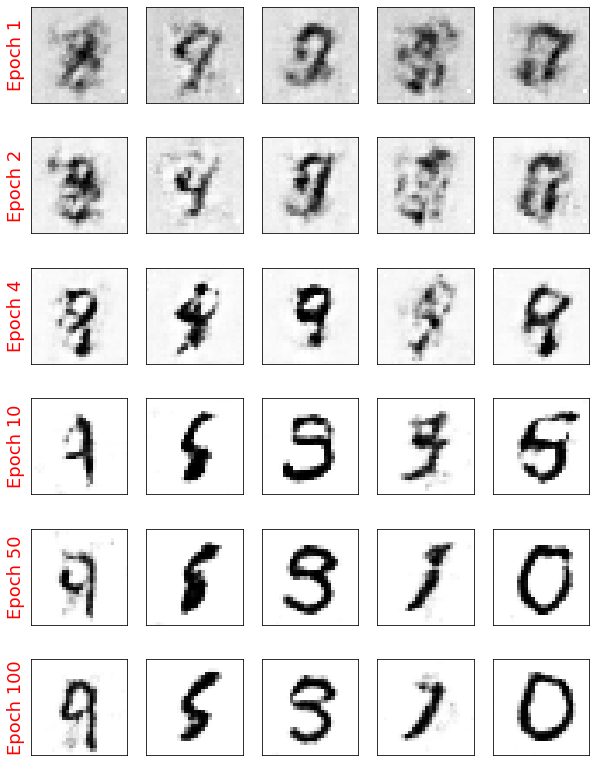

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()
